# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [6]:
!ls pnp_dataset || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip && unzip pnp_dataset.zip >/dev/null 2>&1)

score_x  train_x  train_y.npy


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [8]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [9]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [10]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.20, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

In [11]:
train_y[:5]

array([1, 0, 1, 0, 0])

1

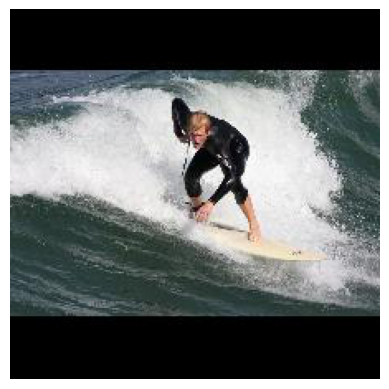

In [12]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

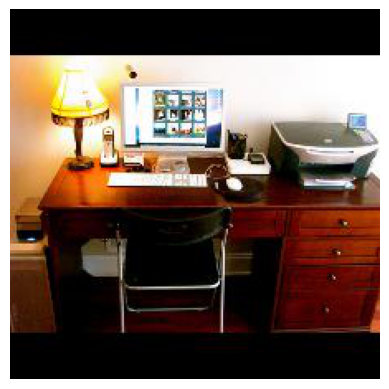

In [13]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [14]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-10-09 14:49:01.457772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:49:08.633560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:49:08.634494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [81]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [82]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [69]:
# mobile_net.summary()

In [70]:
# from kerastuner.engine.hyperparameters import HyperParameters

# model = tf.keras.models.Sequential([
#     mobile_net,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=256),
#     tf.keras.layers.Dense(units=1)
# ])

In [71]:
# model = tf.keras.models.Sequential([
#     mobile_net,
#     tf.keras.layers.AvgPool2D(pool_size=(7, 7)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=256, activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(units=1, activation="sigmoid")
# ])

In [72]:
# model = tf.keras.models.Sequential([
#     mobile_net,
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=256, activation="relu"),
#     tf.keras.layers.Dropout(rate=0.3),
#     tf.keras.layers.Dense(units=1, activation="sigmoid")
# ])

In [88]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [89]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_4 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_7 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 256)               327936    
                                                                 
 dropout_12 (Dropout)        (None, 256)              

In [90]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [91]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    val_x = tf.constant(val_x)
    val_y = tf.constant(val_y)
    test_x = tf.constant(test_x)
    test_y = tf.constant(test_y)
    score_x = tf.constant(score_x)

In [92]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(
    train_x,
    train_y,
    epochs=64,
    callbacks=[callback],
    validation_data=(val_x, val_y),
    batch_size=batch_size
)

Epoch 1/64
375/375 [==============================] - 141s 371ms/step - loss: 0.6429 - binary_accuracy: 0.6302 - val_loss: 0.6072 - val_binary_accuracy: 0.6689
Epoch 2/64
375/375 [==============================] - 139s 370ms/step - loss: 0.6107 - binary_accuracy: 0.6615 - val_loss: 0.5965 - val_binary_accuracy: 0.6758
Epoch 3/64
375/375 [==============================] - 139s 370ms/step - loss: 0.5992 - binary_accuracy: 0.6727 - val_loss: 0.5858 - val_binary_accuracy: 0.6873
Epoch 4/64
375/375 [==============================] - 139s 370ms/step - loss: 0.5907 - binary_accuracy: 0.6800 - val_loss: 0.5796 - val_binary_accuracy: 0.6921
Epoch 5/64
375/375 [==============================] - 139s 371ms/step - loss: 0.5847 - binary_accuracy: 0.6831 - val_loss: 0.5790 - val_binary_accuracy: 0.6934
Epoch 6/64
375/375 [==============================] - 139s 371ms/step - loss: 0.5781 - binary_accuracy: 0.6907 - val_loss: 0.5756 - val_binary_accuracy: 0.6956
Epoch 7/64
375/375 [====================

In [97]:
mobile_net.trainable = True

In [98]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(
    train_x,
    train_y,
    epochs=64,
    callbacks=[callback],
    validation_data=(val_x, val_y),
    batch_size=batch_size
)

Epoch 1/64
375/375 [==============================] - 138s 368ms/step - loss: 0.5320 - binary_accuracy: 0.7239 - val_loss: 0.5685 - val_binary_accuracy: 0.7019
Epoch 2/64
375/375 [==============================] - 139s 370ms/step - loss: 0.5265 - binary_accuracy: 0.7290 - val_loss: 0.5709 - val_binary_accuracy: 0.7009
Epoch 3/64
375/375 [==============================] - 139s 370ms/step - loss: 0.5220 - binary_accuracy: 0.7356 - val_loss: 0.5719 - val_binary_accuracy: 0.7031
Epoch 4/64
375/375 [==============================] - 139s 371ms/step - loss: 0.5188 - binary_accuracy: 0.7368 - val_loss: 0.5729 - val_binary_accuracy: 0.6984


In [99]:
from sklearn.metrics import accuracy_score
train_predicted = model.predict(train_x, batch_size=batch_size)
accuracy_score(train_y, np.where(train_predicted >= 0.5, 1, 0))

0.774625

In [100]:
val_predicted = model.predict(val_x, batch_size=batch_size)
accuracy_score(val_y, np.where(val_predicted >= 0.5, 1, 0))

0.698375

In [101]:
test_predicted = model.predict(test_x, batch_size=batch_size)
accuracy_score(test_y, np.where(test_predicted >= 0.5, 1, 0))

0.6954375

In [102]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset